*Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.*

*Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?*

*После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.*

План проекта:

1)[Подготовка данных](#Подготовка-данных)

2)[Изучить и проверить данные](#Изучить-и-проверить-данные)

3)[Изучить воронку событий](#Изучить-воронку-событий)

4)[Изучить результаты эксперимента](#Изучить-результаты-эксперимента)

5)[Общий вывод](#Общий-вывод)

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats as st
from statsmodels.stats import weightstats as stests
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.proportion import proportions_ztest

data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Заменить названия столбцов на удобные 

In [2]:
data = data.rename(columns={"EventName": "event_name", "DeviceIDHash": "id", "EventTimestamp": "event_time", "ExpId": "expid"})
data

,event_name,id,event_time,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Проверить пропуски и типы данных. Откорректировать, если нужно

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_name    244126 non-null object
id            244126 non-null int64
event_time    244126 non-null int64
expid         244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
#формат столбца eventtime необходимо поменять 
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

In [5]:
data.describe()

,id,expid
count,2.441260e+05,244126.000000
mean,4.627568e+18,247.022296
std,2.642425e+18,0.824434
min,6.888747e+15,246.000000
25%,2.372212e+18,246.000000
50%,4.623192e+18,247.000000
75%,6.932517e+18,248.000000
max,9.222603e+18,248.000000


In [6]:
# проверим данные на дубликаты
data.duplicated().sum()

413

In [7]:
data = data.drop_duplicates()

### Добавить столбец даты и времени, а также отдельный столбец дат

In [8]:
data['event_date'] = data['event_time'].dt.date
data

,event_name,id,event_time,expid,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


*В датасете есть небольшая доля дубликатов. Думаю, что это пользователи, попавшие сразу в несколько групп или совершившие несколько одинаковых действий. Дата и время хранятся в базе данных в виде Timestamp - помогает для сокращения памяти и места но не для анализа.*

## Изучить и проверить данные

### Сколько всего событий в логе? Сколько всего пользователей в логе? Сколько в среднем событий приходится на пользователя?

In [9]:
data['event_name'].nunique()

5

In [10]:
data['id'].nunique()

7551

In [11]:
data.groupby('id')['event_name'].count().mean()

32.27559263673685

###  Найти максимальную и минимальную дату. Построить гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Определить, с какого момента данные полные и отбросить более старые.

In [12]:
print(data['event_date'].max(), data['event_date'].min())

2019-08-07 2019-07-25


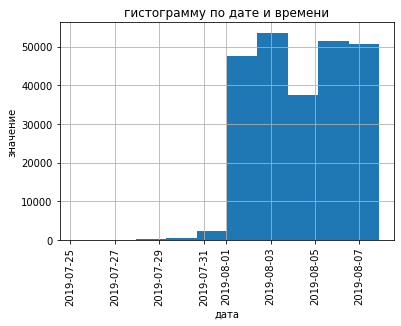

In [13]:
data['event_time'].hist()
plt.title('гистограмму по дате и времени')
plt.xlabel('дата')
plt.ylabel('значение')
degrees = 90
plt.xticks(rotation=degrees)
plt.show()

*C 2019-08-01 данные более полные, все что раньше принято отбросить.*

In [14]:
df = data.query('event_time >= "2019-08-01"')
df

,event_name,id,event_time,expid,event_date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [15]:
#проверим, что у нас есть пользователи из всех трёх экспериментальных групп.
df['expid'].unique()

array([246, 247, 248])

In [16]:
# вычислим, какой процент уникальных пользователей и какой процент событий мы исключили из рассмотрения
print(100 - (df['id'].nunique()/data['id'].nunique() * 100))
print(100 - (df['event_name'].count()/data['event_name'].count() * 100))


0.22513574361011024
1.1595606307418933


*Было исключено 022% уникальных пользователей и 1.15% событий*

## Изучить воронку событий

### Посмотреть, какие события есть в логах, как часто они встречаются. Отсортировать события по частоте

In [17]:
df.groupby('event_name').agg({'id': 'count'}).sort_values(by='id', ascending=False)

,id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


*Больше половины пользователей уходят из приложения с главной страницы, не говоря уже о прохождения руководства по пользованию*

### Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие.

In [18]:
df.groupby('event_name').agg({'id': 'nunique'}).sort_values(by='id', ascending=False)

,id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [19]:
(df.groupby('event_name').agg({'id': 'nunique'})/df['id'].nunique()).sort_values(by='id', ascending=False)

,id
event_name,
MainScreenAppear,0.984736
OffersScreenAppear,0.609636
CartScreenAppear,0.495620
PaymentScreenSuccessful,0.469737
Tutorial,0.111495


### Предположить, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?

*Порядок сохраняеться событий сохраняется в правильной последовательности, кроме Tutorial. При общем количестве пользователей 7419 человека, только 840 перешли от обучения к главной странице приложения*

### По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [20]:
proportion = pd.pivot_table(df, index='id', columns='event_name', values='event_time', aggfunc='min')
proportion

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
id,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT
...,...,...,...,...,...
9217594193087726423,2019-08-02 09:00:58,NaT,2019-08-02 09:01:08,2019-08-02 09:00:57,NaT
9219463515465815368,2019-08-06 16:49:40,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:52:16,NaT
9220879493065341500,2019-08-02 17:59:16,2019-08-02 17:58:48,2019-08-02 17:59:00,NaT,NaT


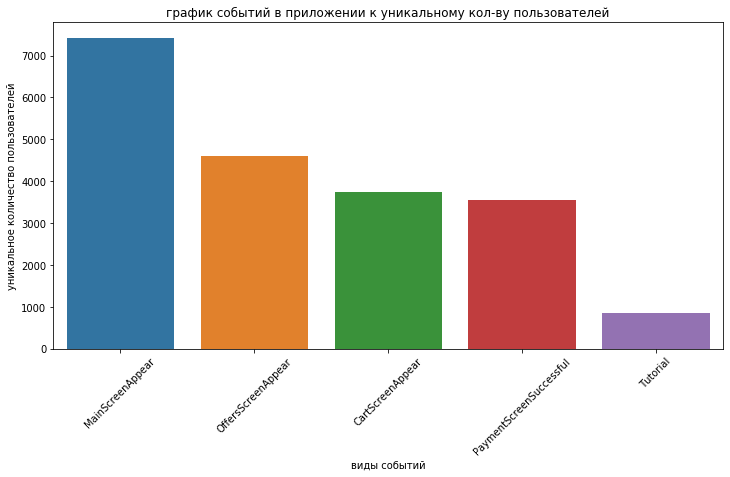

In [21]:
df_mean = df.groupby('event_name')['id'].nunique().reset_index().sort_values(by = 'id', ascending=False)
plot_order = data.sort_values(by='event_name', ascending=False).id.values
plt.figure(figsize=(12, 6))
g = sns.barplot(x='event_name', y='id', data=df_mean);
g.set(xlabel="виды событий", ylabel="уникальное количество пользователей");
title = ('график событий в приложении к уникальному кол-ву пользователей')
g.set(title=title);
plt.xticks(rotation=45);

*Стоит отметить сбой при сборе данных. Пользователи платят раньше, чем оформляют товары, не указывается время прихода пользователя в приложение, хотя оформляют и покупают продукцию*

In [22]:
step_1 = ~proportion['Tutorial'].isna()
step_2 = step_1 & (proportion['MainScreenAppear'] > proportion['Tutorial'])
step_3 = step_1 & (proportion['CartScreenAppear'] > proportion['MainScreenAppear'])
step_4 = step_2 & (proportion['OffersScreenAppear'] > proportion['CartScreenAppear'])
step_5 = step_3 & (proportion['PaymentScreenSuccessful'] > proportion['OffersScreenAppear'])

n_Tutorial = proportion[step_1].shape[0]
n_MainScreenAppear = proportion[step_2].shape[0]
n_CartScreenAppear = proportion[step_3].shape[0]
n_OffersScreenAppear = proportion[step_4].shape[0]
n_PaymentScreenSuccessful = proportion[step_5].shape[0]

print('Прошли обучение:', n_Tutorial)
print('Посетителей:', n_MainScreenAppear,
      'Доля перешедших пользователей:', n_MainScreenAppear/n_Tutorial * 100)
print('Добавили товара в корзину:', n_CartScreenAppear, 
      'Доля перешедших пользователей:', n_CartScreenAppear/n_MainScreenAppear * 100)
print('Начали оформлять заказ:', n_OffersScreenAppear, 
      'Доля перешедших пользователей:', n_OffersScreenAppear/n_CartScreenAppear * 100)
print('Оплатили:', n_PaymentScreenSuccessful, 
      'Доля перешедших пользователей:', n_PaymentScreenSuccessful/n_OffersScreenAppear * 100)

Прошли обучение: 840
Посетителей: 787 Доля перешедших пользователей: 93.69047619047619
Добавили товара в корзину: 535 Доля перешедших пользователей: 67.97966963151208
Начали оформлять заказ: 161 Доля перешедших пользователей: 30.093457943925234
Оплатили: 410 Доля перешедших пользователей: 254.6583850931677


### На каком шаге теряется больше всего пользователей?Какая доля пользователей доходит от первого события до оплаты?

In [23]:
#Больше всего теряется пользователей на оформлении заказа - только 30% оформляют заказ после его добавления в корзину
#Долю пользователей, доходящих от первого события до оплаты найдем по формуле  n_Tutorial/n_PaymentScreenSuccessful * 100
n_PaymentScreenSuccessful/n_Tutorial * 100

48.80952380952381

*48% пользователей доходит от первого события до оплаты*

## Изучить результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [24]:
df.groupby('expid').agg({'id': 'nunique'}).sort_values(by='id', ascending=False).reset_index()

,expid,id
0,248,2537
1,247,2513
2,246,2484


### Проверить, находят ли статистические критерии разницу между выборками 246 и 247

Н_0: Доля группы 246 = Доля группы 247

Н_1: Доля группы 246 != Доля группы 247

In [25]:
df_246 = df.query('expid == "246"').groupby('event_name').agg({'id': 'nunique'}).reset_index()
df_246

,event_name,id
0,CartScreenAppear,1266
1,MainScreenAppear,2450
2,OffersScreenAppear,1542
3,PaymentScreenSuccessful,1200
4,Tutorial,278


In [26]:
df_247 = df.query('expid == "247"').groupby('event_name').agg({'id': 'nunique'}).reset_index()
df_247

,event_name,id
0,CartScreenAppear,1238
1,MainScreenAppear,2476
2,OffersScreenAppear,1520
3,PaymentScreenSuccessful,1158
4,Tutorial,283


In [27]:
df.query('expid == "246"')['id'].nunique()

2484

In [28]:
df.query('expid == "247"')['id'].nunique()

2513

In [29]:
df_246 = df_246.set_index('event_name')
df_247 = df_247.set_index('event_name')

In [30]:
count = (df_246.loc['MainScreenAppear', 'id'], df_247.loc['MainScreenAppear', 'id'])
nobs = (df.query('expid == "246"')['id'].nunique(), df.query('expid == "247"')['id'].nunique())
stat, pval = proportions_ztest(count, nobs)
print(float(pval))
if pval < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.7570597232046099
Не получилось отвергнуть нулевую гипотезу


*По итогу z-теста, доли не имеют статистическую разницу, а это значит, что мы можем быть уверены в точности проведенного тестирования*

### Выберать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Проделать то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [31]:
df_246_and_247 = df_246 + df_247
df.query('expid == "246" | expid == "247"').groupby('event_name').agg({'id': 'nunique'}).reset_index()
df_246_and_247

,id
event_name,
CartScreenAppear,2504
MainScreenAppear,4926
OffersScreenAppear,3062
PaymentScreenSuccessful,2358
Tutorial,561


In [32]:
# Самым популярным событием является MainScreenAppear
df_248 = df.query('expid == "248"').groupby('event_name').agg({'id': 'nunique'}).reset_index()
df_248 = df_248.set_index('event_name')
df.query('expid == "248"')['id'].nunique()

2537

In [33]:
print(df_248)

                           id
event_name                   
CartScreenAppear         1230
MainScreenAppear         2493
OffersScreenAppear       1531
PaymentScreenSuccessful  1181
Tutorial                  279


In [34]:
print(df_247)

                           id
event_name                   
CartScreenAppear         1238
MainScreenAppear         2476
OffersScreenAppear       1520
PaymentScreenSuccessful  1158
Tutorial                  283


In [35]:
print(df_246)

                           id
event_name                   
CartScreenAppear         1266
MainScreenAppear         2450
OffersScreenAppear       1542
PaymentScreenSuccessful  1200
Tutorial                  278


In [36]:
# Посчитаем долю пользователей, совершивших это событие
print(df_248.iloc[1]['id']/df.query('expid == "248"')['id'].nunique())
print(df_247.iloc[1]['id']/df.query('expid == "247"')['id'].nunique())
print(df_246.iloc[1]['id']/df.query('expid == "246"')['id'].nunique())

0.9826566811194324
0.9852765618782332
0.9863123993558777


*Проверим, будет ли отличие между группами статистически достоверным*

Н_0: Доля группы 246 = Доля группы 247

Н_1: Доля группы 246 != Доля группы 247

Н_0: Доля группы 246 = Доля группы 248

Н_1: Доля группы 246 != Доля группы 248

Н_0: Доля группы 247 = Доля группы 248

Н_1: Доля группы 247 != Доля группы 248

Н_0: Доля группы 246 + 247 = Доля группы 248

Н_1: Доля группы 246 + 247 != Доля группы 248

In [37]:
for event_name in df_246.index.to_list():
    print(event_name)
    count = (df_246.loc[event_name, 'id'], df_247.loc[event_name, 'id'])
    nobs = (df.query('expid == "246"')['id'].nunique(), df.query('expid == "247"')['id'].nunique())
    stat, pval = proportions_ztest(count, nobs)
    print(float(pval))
    if pval < 0.05:
        print("Отвергаем нулевую гипотезу: в конверсии двух групп есть статистически значимые различия")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий")

CartScreenAppear
0.22883372237997213
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
MainScreenAppear
0.7570597232046099
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
OffersScreenAppear
0.2480954578522181
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
PaymentScreenSuccessful
0.11456679313141847
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
Tutorial
0.9376996189257114
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий


In [38]:
for event_name in df_246.index.to_list():
    print(event_name)
    count = (df_246.loc[event_name, 'id'], df_248.loc[event_name, 'id'])
    nobs = (df.query('expid == "246"')['id'].nunique(), df.query('expid == "248"')['id'].nunique())
    stat, pval = proportions_ztest(count, nobs)
    print(float(pval))
    if pval < 0.05:
        print("Отвергаем нулевую гипотезу: в конверсии двух групп есть статистически значимые различия")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий")

CartScreenAppear
0.07842923237520125
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
MainScreenAppear
0.2949721933554553
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
OffersScreenAppear
0.20836205402738917
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
PaymentScreenSuccessful
0.21225532756977972
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
Tutorial
0.8264294010087645
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий


In [39]:
for event_name in df_247.index.to_list():
    print(event_name)
    count = (df_247.loc[event_name, 'id'], df_248.loc[event_name, 'id'])
    nobs = (df.query('expid == "247"')['id'].nunique(), df.query('expid == "248"')['id'].nunique())
    stat, pval = proportions_ztest(count, nobs)
    print(float(pval))
    if pval < 0.05:
        print("Отвергаем нулевую гипотезу: в конверсии двух групп есть статистически значимые различия")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий")

CartScreenAppear
0.5786197879539782
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
MainScreenAppear
0.45870536166215137
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
OffersScreenAppear
0.919781783059226
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
PaymentScreenSuccessful
0.7373415053803964
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
Tutorial
0.7653239224745011
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий


In [40]:
for event_name in df_246_and_247.index.to_list():
    print(event_name)
    count = (df_246_and_247.loc[event_name, 'id'], df_248.loc[event_name, 'id'])
    nobs = (df.query('expid == "246" | expid == "247"')['id'].nunique(), df.query('expid == "248"')['id'].nunique())
    stat, pval = proportions_ztest(count, nobs)
    print(float(pval))
    if pval < 0.05:
        print("Отвергаем нулевую гипотезу: в конверсии двух групп есть статистически значимые различия")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий")

CartScreenAppear
0.18175875284404386
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
MainScreenAppear
0.29424526837179577
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
OffersScreenAppear
0.43425549655188245
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
PaymentScreenSuccessful
0.6004294282308703
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
Tutorial
0.764862472531507
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий


*В каждом тесте при каждом событии не доказано статистически достоверное различие между долями групп*

### Аналогично поступить с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

*Первая часть задания была проделана в предыдущем пункте*

*По сравнительному тесту доли контрольных группы и экспериментальной не имеют статистически достоверных различий. А значит группы распределены корректно*

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

In [41]:
for event_name in df_246.index.to_list():
    print(event_name)
    count = (df_246.loc[event_name, 'id'], df_247.loc[event_name, 'id'])
    nobs = (df.query('expid == "246"')['id'].nunique(), df.query('expid == "247"')['id'].nunique())
    stat, pval = proportions_ztest(count, nobs)
    print(float(pval))
    if pval < 0.1:
        print("Отвергаем нулевую гипотезу: в конверсии двух групп есть статистически значимые различия")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий")

CartScreenAppear
0.22883372237997213
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
MainScreenAppear
0.7570597232046099
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
OffersScreenAppear
0.2480954578522181
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
PaymentScreenSuccessful
0.11456679313141847
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
Tutorial
0.9376996189257114
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий


In [42]:
for event_name in df_246.index.to_list():
    print(event_name)
    count = (df_246.loc[event_name, 'id'], df_248.loc[event_name, 'id'])
    nobs = (df.query('expid == "246"')['id'].nunique(), df.query('expid == "248"')['id'].nunique())
    stat, pval = proportions_ztest(count, nobs)
    print(float(pval))
    if pval < 0.1:
        print("Отвергаем нулевую гипотезу: в конверсии двух групп есть статистически значимые различия")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий")

CartScreenAppear
0.07842923237520125
Отвергаем нулевую гипотезу: в конверсии двух групп есть статистически значимые различия
MainScreenAppear
0.2949721933554553
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
OffersScreenAppear
0.20836205402738917
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
PaymentScreenSuccessful
0.21225532756977972
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
Tutorial
0.8264294010087645
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий


In [43]:
for event_name in df_247.index.to_list():
    print(event_name)
    count = (df_247.loc[event_name, 'id'], df_248.loc[event_name, 'id'])
    nobs = (df.query('expid == "247"')['id'].nunique(), df.query('expid == "248"')['id'].nunique())
    stat, pval = proportions_ztest(count, nobs)
    print(float(pval))
    if pval < 0.1:
        print("Отвергаем нулевую гипотезу: в конверсии двух групп есть статистически значимые различия")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий")

CartScreenAppear
0.5786197879539782
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
MainScreenAppear
0.45870536166215137
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
OffersScreenAppear
0.919781783059226
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
PaymentScreenSuccessful
0.7373415053803964
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
Tutorial
0.7653239224745011
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий


In [44]:
for event_name in df_246_and_247.index.to_list():
    print(event_name)
    count = (df_246_and_247.loc[event_name, 'id'], df_248.loc[event_name, 'id'])
    nobs = (df.query('expid == "246" | expid == "247"')['id'].nunique(), df.query('expid == "248"')['id'].nunique())
    stat, pval = proportions_ztest(count, nobs)
    print(float(pval))
    if pval < 0.1:
        print("Отвергаем нулевую гипотезу: в конверсии двух групп есть статистически значимые различия")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий")

CartScreenAppear
0.18175875284404386
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
MainScreenAppear
0.29424526837179577
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
OffersScreenAppear
0.43425549655188245
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
PaymentScreenSuccessful
0.6004294282308703
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий
Tutorial
0.764862472531507
Не получилось отвергнуть нулевую гипотезу: в конверсии двух групп нет статистически значимых различий


*Мной был выбран уровень значимости 0,05. После проведения тестов с уровнем 0.1 я считаю подтвердилась гипотеза о том, что каждый десятый раз можно получать ложный результат. Из всех выводов только один отличается. Да, в основном, вывода будут идентичны, но при значении 0,05 есть только 5% совершить ошибку первого рода и отклонить нулевую гипотезу, когда она верна, тогда как при 0,1 - это 10%, а ошибатся не хочется.*

## Общий вывод

*Передо мной стояло несколько целей:*

*— разобраться, как ведут себя пользователи нашего мобильного приложения*

*— узнать, как пользователи доходят до покупки*

*— сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?*

*— исследовать результаты A/A/B-эксперимента и выяснить какой шрифт лучше*

*Я работал с датасетом, имеющий информацию о событиях в приложении(EventName), когда они были сделаны(EventTimestamp), каким пользователем(DeviceIDHash), находящимся в определенной группе (ExpId) - контрольной 246 и 247 или экспериментальной 248*

*Перед анализом проведена работа с данными, а именно: подсчет количества событий(5 шт) и пользователей в логе(7551 чел), отсечены старые и непольные данные, что могли повлиять на исход работы. Дальнейший анализ был произведен с 2019-08-01*

*Анализ воронки событий показал:*

*1)События по популярности*

*- MainScreenAppear с 7419  пользователями , что составляет 98% от всех пользователей*

*- OffersScreenAppear с 4593 пользователями , что составляет 60% от всех пользователей*

*- CartScreenAppear с 3734 пользователями , что составляет 49% от всех пользователей*

*- PaymentScreenSuccessful с 3539 пользователями , что составляет 46% от всех пользователей*

*- Tutorial с 840пользователями , что составляет 11% от всех пользователей*

*2) доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)*

*Прошли обучение: 840*

*Посетителей: 787 Доля перешедших пользователей: 93.69047619047619*

*Добавили товара в корзину: 535 Доля перешедших пользователей: 67.97966963151208*

*Начали оформлять заказ: 161 Доля перешедших пользователей: 30.093457943925234*

*Оплатили: 410 Доля перешедших пользователей: 254.6583850931677*

*3) Больше всего теряется пользователей на оформлении заказа - только 30% оформляют заказ после его добавления в корзину*
*Долю пользователей, доходящих от первого события до оплаты,  составляет 48% пользователей*

*4)В каждой группе практически равное количество пользователей, что положительно повлияло на результаты А\В теста. В группе 246 – 2484 чел, 247 – 2513 чел, 248 – 2537 чел*

*5) По результатам теста , по каждой группе пользователей и каждому событию в приложении, равенство долей было статистически достоверным, что не дает право отдать победу одной из групп*


*По итогу всего перечисленного стоит отметить, что пользователи практически не проходят обучение по пользованию приложения, либо ссылаются к нему во время определенных проблем. Большие потери пользователей происходит на этапе оформления заказа - необходимо узнать, что именно им может мешать произвести после этого оплату. Только половина пользователей доходит от входа в приложение до оплаты товара. В среднем 63% пользователей на каждом этапе. Не удалось выяснить какой шрифт лучше, поскольку количество пользователей в каждом событии было одинаковым, в не зависимости от группы. Предлагаю продлить тест на минимально возможный срок для выявления более точных результатов тестов, дабы не потратить на это излишних денег и времени*